<a href="https://colab.research.google.com/github/Ninja-draw-coder/PythonProjects/blob/main/MyNextMovie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie-Lens Mini-Project
1. Data & Tools Imports

In [15]:
# ----------------------------------------------------------
# 0. Imports & data load
# ----------------------------------------------------------
# 0 ─────────────────────────────────────────────────────────
# Libraries & data load
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
sns.set_theme(style='whitegrid')

movies  = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
print('Movies:', movies.shape, 'Ratings:', ratings.shape)

Movies: (10329, 3) Ratings: (105339, 4)


# Exploratory Data Analysis

# 1. High-Level EDA

In [4]:
# ----------------------------------------------------------
# 1. Basic EDA  (just a few lines; expand if you wish)
# ----------------------------------------------------------
n_users   = ratings['userId'].nunique()
n_movies  = ratings['movieId'].nunique()
mean_rate = ratings['rating'].mean()
print('Unique users :', n_users)
print('Unique movies:', n_movies)
print('Avg rating   :', round(mean_rate,3))

# explode the genres column so one row per (movie,genre)
movies_expl = (
    movies
    .assign(genres = movies['genres'].str.split('|'))
    .explode('genres')
)

# genre-level aggregates
genre_stats = (
    movies_expl
    .merge(ratings, on='movieId')
    .groupby('genres')
    .agg(avg_rating  = ('rating','mean'),
         n_ratings   = ('rating','size'),
         n_movies    = ('movieId','nunique'))
    .sort_values('n_ratings', ascending=False)
)
genre_stats.head()

Unique users : 668
Unique movies: 10325
Avg rating   : 3.517


,avg_rating,n_ratings,n_movies
genres,,,
Drama,3.650266,46960,5218
Comedy,3.420996,38055,3513
Action,3.451450,31205,1737
Thriller,3.495561,29288,2187
Adventure,3.518027,23076,1164


# 1.1 Ratings distribution

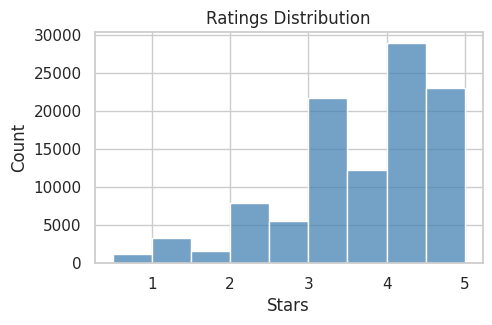

In [16]:
# Histogram of rating values
plt.figure(figsize=(5,3))
sns.histplot(ratings['rating'], bins=9, color='steelblue')
plt.title('Ratings Distribution');
plt.xlabel('Stars');
plt.ylabel('Count')
plt.show()

# 1.2 #Ratings per User / per Movie

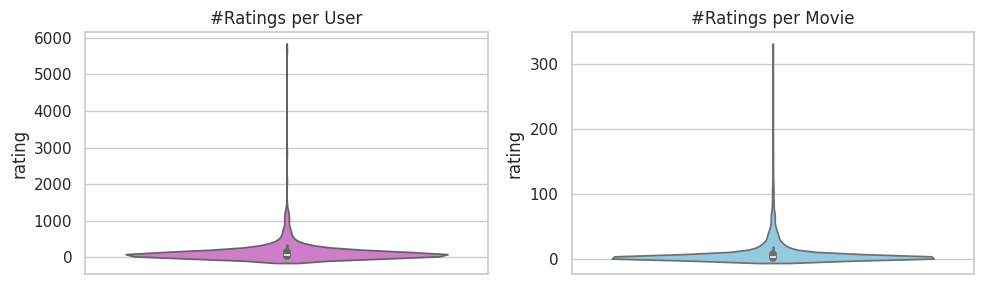

In [17]:
# Two side-by-side violin plots
counts_u = ratings.groupby('userId')['rating'].count()
counts_m = ratings.groupby('movieId')['rating'].count()

fig, ax = plt.subplots(1,2, figsize=(10,3))
sns.violinplot(y=counts_u, ax=ax[0], color='orchid');  ax[0].set_title('#Ratings per User')
sns.violinplot(y=counts_m, ax=ax[1], color='skyblue'); ax[1].set_title('#Ratings per Movie')
plt.tight_layout(); plt.show()


# 1.3 Genre frequency

/tmp/ipython-input-18-2821891993.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_ct.index, y=genre_ct.values, palette='viridis')


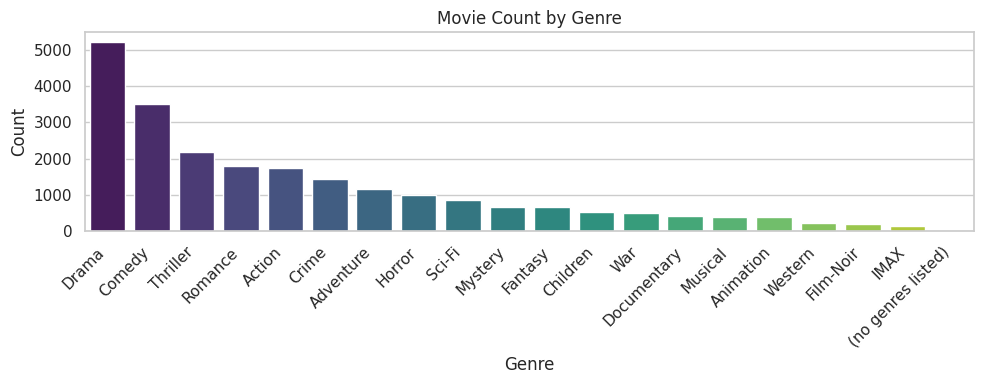

In [18]:
genres_expl = (movies.assign(genre = movies['genres'].str.split('|'))
                       .explode('genre'))
genre_ct     = genres_expl['genre'].value_counts()

plt.figure(figsize=(10,4))
sns.barplot(x=genre_ct.index, y=genre_ct.values, palette='viridis')
plt.xticks(rotation=45, ha='right'); plt.title('Movie Count by Genre')
plt.ylabel('Count'); plt.xlabel('Genre')
plt.tight_layout(); plt.show()

# Recommendation Modules
# Module A – Popularity-by-Genre

In [19]:
# ----------------------------------------------------------
# 2a. POPULARITY-BY-GENRE RECOMMENDER
# ----------------------------------------------------------
def pop_genre_recommender(genre:str,
                          min_reviews:int = 100,
                          top_n:int = 5):
    """
    Returns top_n movies within `genre` that have at least
    `min_reviews` ratings, ordered by avg rating then #ratings.
    """
    df = (
        movies_expl[movies_expl['genres']==genre]
        .merge(ratings, on='movieId')
        .groupby(['movieId','title'], as_index=False)
        .agg(avg_rating = ('rating','mean'),
             num_reviews= ('rating','size'))
    )
    df = (
        df[df['num_reviews']>=min_reviews]
        .sort_values(['avg_rating','num_reviews'],
                     ascending=[False,False])
        .head(top_n)
        .reset_index(drop=True)
    )
    df.index = np.arange(1, len(df)+1)   # 1-based S.No
    return df[['title','avg_rating','num_reviews']]

# ---- demo
pop_genre_recommender('Comedy', 100, 5)

,title,avg_rating,num_reviews
1,Monty Python and the Holy Grail (1975),4.301948,154
2,Fargo (1996),4.271144,201
3,"Princess Bride, The (1987)",4.163743,171
4,Pulp Fiction (1994),4.160000,325
5,Forrest Gump (1994),4.138264,311


/tmp/ipython-input-22-1161270144.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='title', y='avg_rating', data=agg,
/tmp/ipython-input-22-1161270144.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout();


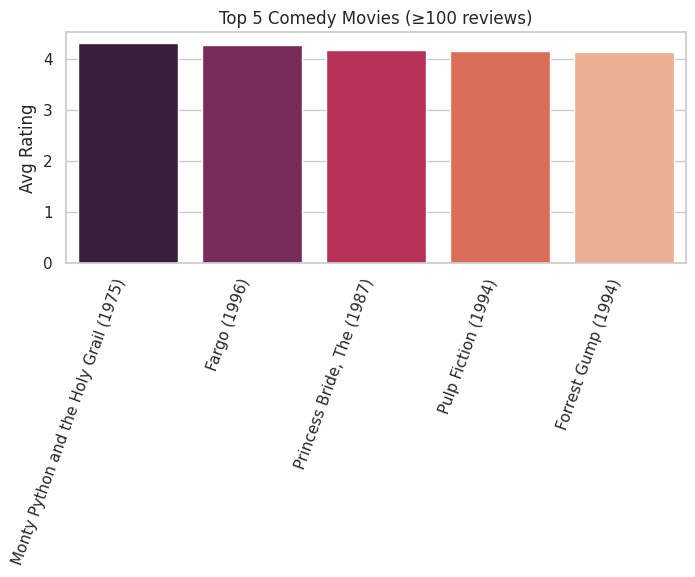

,title,avg_rating,num_reviews
0,Monty Python and the Holy Grail (1975),4.301948,154
1,Fargo (1996),4.271144,201
2,"Princess Bride, The (1987)",4.163743,171
3,Pulp Fiction (1994),4.160000,325
4,Forrest Gump (1994),4.138264,311


In [22]:
def pop_genre_recommender(genre, min_reviews=50, top_n=10, plot=True):
    """Return top_n movies in <genre> with ≥min_reviews."""
    sub = genres_expl[genres_expl['genre']==genre]      # 1 genre slice
    joined = sub.merge(ratings, on='movieId')           # attach ratings
    agg = (joined.groupby(['movieId','title'])
                  .agg(avg_rating=('rating','mean'),
                       num_reviews=('rating','size'))
                  .query('num_reviews >= @min_reviews')
                  .sort_values(['avg_rating','num_reviews'], ascending=False)
                  .head(top_n)
                  .reset_index())

    if plot:                                            # bar chart
        plt.figure(figsize=(8,3))
        sns.barplot(x='title', y='avg_rating', data=agg,
                     order=agg['title'], palette='rocket')
        plt.xticks(rotation=70, ha='right')
        plt.title('Top {} {} Movies (≥{} reviews)'
                  .format(top_n, genre, min_reviews))
        plt.ylabel('Avg Rating'); plt.xlabel('')
        plt.tight_layout();
        plt.show()
    return agg[['title','avg_rating','num_reviews']]

# ---- demo
pop_genre_recommender('Comedy', 100, 5)


# Module B – Global Popularity

In [6]:
# ----------------------------------------------------------
# 2b. PURE POPULARITY RECOMMENDER (no genre filter)
#     – simple baseline
# ----------------------------------------------------------
def global_popularity(top_n:int=10, min_reviews:int=50):
    df = (
        ratings
        .groupby('movieId')
        .agg(avg_rating=('rating','mean'),
             num_reviews=('rating','size'))
        .merge(movies[['movieId','title']], on='movieId')
    )
    df = (
        df[df['num_reviews']>=min_reviews]
        .sort_values(['avg_rating','num_reviews'],
                     ascending=[False,False])
        .head(top_n)
        .reset_index(drop=True)
    )
    df.index = np.arange(1, len(df)+1)
    return df[['title','avg_rating','num_reviews']]

# ---- demo
global_popularity(10, 200)

,title,avg_rating,num_reviews
1,"Shawshank Redemption, The (1994)",4.454545,308
2,"Godfather, The (1972)",4.392857,210
3,"Usual Suspects, The (1995)",4.328947,228
4,Schindler's List (1993),4.296371,248
5,Fargo (1996),4.271144,201
6,"Matrix, The (1999)",4.264368,261
7,Star Wars: Episode V - The Empire Strikes Back...,4.228070,228
8,Raiders of the Lost Ark (Indiana Jones and the...,4.212054,224
9,"Silence of the Lambs, The (1991)",4.194828,290
10,Star Wars: Episode IV - A New Hope (1977),4.188645,273


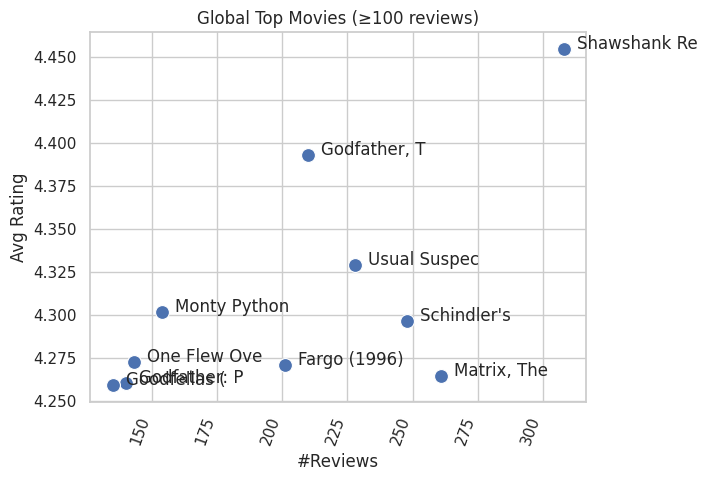

,title,avg_rating,num_reviews
0,"Shawshank Redemption, The (1994)",4.454545,308
1,"Godfather, The (1972)",4.392857,210
2,"Usual Suspects, The (1995)",4.328947,228
3,Monty Python and the Holy Grail (1975),4.301948,154
4,Schindler's List (1993),4.296371,248
5,One Flew Over the Cuckoo's Nest (1975),4.272727,143
6,Fargo (1996),4.271144,201
7,"Matrix, The (1999)",4.264368,261
8,"Godfather: Part II, The (1974)",4.260714,140
9,Goodfellas (1990),4.259259,135


In [38]:
def global_popular(min_reviews=100, top_n=10):
    pop = (ratings.groupby('movieId')
                  .agg(avg_rating=('rating','mean'),
                       num_reviews=('rating','size'))
                  .query('num_reviews >= @min_reviews')
                  .sort_values(['avg_rating','num_reviews'], ascending=False)
                  .head(top_n)
                  .reset_index()
                  .merge(movies[['movieId','title']], on='movieId'))
    sns.scatterplot(data=pop, x='num_reviews', y='avg_rating', s=100)
    for _,r in pop.iterrows():
        plt.text(r['num_reviews']+5, r['avg_rating'], r['title'][:12])
    plt.title('Global Top Movies (≥{} reviews)'.format(min_reviews))
    plt.xticks(rotation=60, ha='right')
    plt.xlabel('#Reviews');
    plt.ylabel('Avg Rating');
    plt.show()
    return pop[['title','avg_rating','num_reviews']]

#demo
global_popular(100,10)

# Module C – Item–Item Similarity

In [7]:
# ----------------------------------------------------------
# 2c. ITEM–ITEM (COSINE) SIMILARITY RECOMMENDER
# ----------------------------------------------------------
from sklearn.metrics.pairwise import cosine_similarity

# create a sparse user-movie matrix
user_movie = (
    ratings
    .pivot_table(index='userId',
                 columns='movieId',
                 values='rating')
)

# (fill NaNs with 0 for cosine; small data ⇒ OK in memory)
user_movie_filled = user_movie.fillna(0)
movie_ids = user_movie_filled.columns
cos_sim   = cosine_similarity(user_movie_filled.T)  # movie×movie
cos_df    = pd.DataFrame(cos_sim,
                         index  = movie_ids,
                         columns= movie_ids)

def similar_movies(movie_title:str, top_n:int=5):
    """Return top_n titles most similar to movie_title."""
    # map title ➜ movieId (take first match if duplicates)
    try:
        m_id = movies.loc[movies['title']==movie_title,
                          'movieId'].iloc[0]
    except IndexError:
        raise ValueError('Movie not found – check spelling!')
    # similarity row, drop self
    sims = cos_df.loc[m_id].drop(index=m_id)
    best = sims.nlargest(top_n).index
    return movies.set_index('movieId').loc[best,'title']\
                 .reset_index(drop=True)\
                 .rename('Similar Movie')

# ---- demo
similar_movies('Toy Story (1995)', 5)

,Similar Movie
0,Star Wars: Episode VI - Return of the Jedi (1983)
1,Star Wars: Episode IV - A New Hope (1977)
2,Raiders of the Lost Ark (Indiana Jones and the...
3,Independence Day (a.k.a. ID4) (1996)
4,Back to the Future (1985)


/tmp/ipython-input-37-3266977061.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=best_titles, y=scores[best].values, orient='v', palette=colors)
/tmp/ipython-input-37-3266977061.py:28: UserWarning: 
The palette list has fewer values (4) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=best_titles, y=scores[best].values, orient='v', palette=colors)


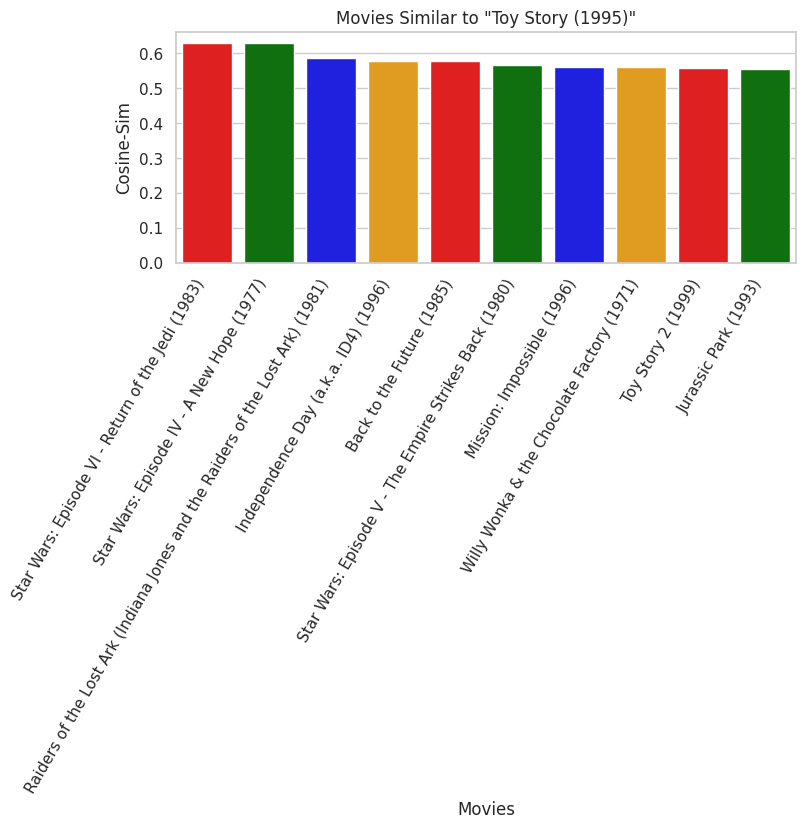

,Similar Movie
0,Star Wars: Episode VI - Return of the Jedi (1983)
1,Star Wars: Episode IV - A New Hope (1977)
2,Raiders of the Lost Ark (Indiana Jones and the...
3,Independence Day (a.k.a. ID4) (1996)
4,Back to the Future (1985)
5,Star Wars: Episode V - The Empire Strikes Back...
6,Mission: Impossible (1996)
7,Willy Wonka & the Chocolate Factory (1971)
8,Toy Story 2 (1999)
9,Jurassic Park (1993)


In [37]:
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# Build sparse ratings-matrix once
user_idx   = ratings['userId'].astype('category').cat.codes
movie_idx  = ratings['movieId'].astype('category').cat.codes
mat = csr_matrix((ratings['rating'],
                  (user_idx, movie_idx)))

# Cache similarity for reuse (optional, use ~1 GB for full 10k × 10k)
sim = cosine_similarity(mat.T, dense_output=False)

movie_id_lookup = dict(zip(movies['title'], movies['movieId']))
id_to_title     = dict(zip(movies['movieId'], movies['title']))

def similar_movies(title, top_n=5, plot=True):
    m_id  = movie_id_lookup.get(title)
    if m_id is None: raise ValueError('Title not found')
    m_col = ratings['movieId'].astype('category').cat.categories.get_loc(m_id)
    scores = pd.Series(sim[m_col].toarray().ravel())
    scores.index = ratings['movieId'].astype('category').cat.categories
    best = (scores.drop(m_id).nlargest(top_n).index)
    best_titles = [id_to_title[i] for i in best]
    if plot:
        plt.figure(figsize=(8,3))
        plt.xticks(rotation=70, ha='right')
        colors = ['red', 'green', 'blue', 'orange']  # Example custom palette
        sns.barplot(x=best_titles, y=scores[best].values, orient='v', palette=colors)


        plt.title('Top {} Similar Movies to "{}"'.format(top_n, title))
        #plt.palplot(sns.color_palette('rocket', n_colors=top_n))
        plt.xlabel('Movies')
        plt.ylabel('Cosine-Sim')
        plt.title('Movies Similar to "'+title+'"')
        plt.xticks(rotation=60)
        plt.title('Movies Similar to "'+title+'"'); plt.xticks(rotation=60)
        plt.show()
    return pd.DataFrame({'Similar Movie':best_titles})

#demo
similar_movies('Toy Story (1995)', 10)


In [8]:
# Quick prompt-style interaction
while True:
    g = input('Genre (or blank to quit): ')
    if g == '':
        break
    t = int(input('Min #reviews: '))
    n = int(input('How many recommendations? '))
    print(pop_genre_recommender(g, t, n))

Genre (or blank to quit): drama
Min #reviews: 5
How many recommendations? 5
Empty DataFrame
Columns: [title, avg_rating, num_reviews]
Index: []
Genre (or blank to quit): 


genre
Drama       5220
Comedy      3515
Thriller    2187
Romance     1788
Action      1737
Name: count, dtype: int64


/tmp/ipython-input-9-3831462045.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


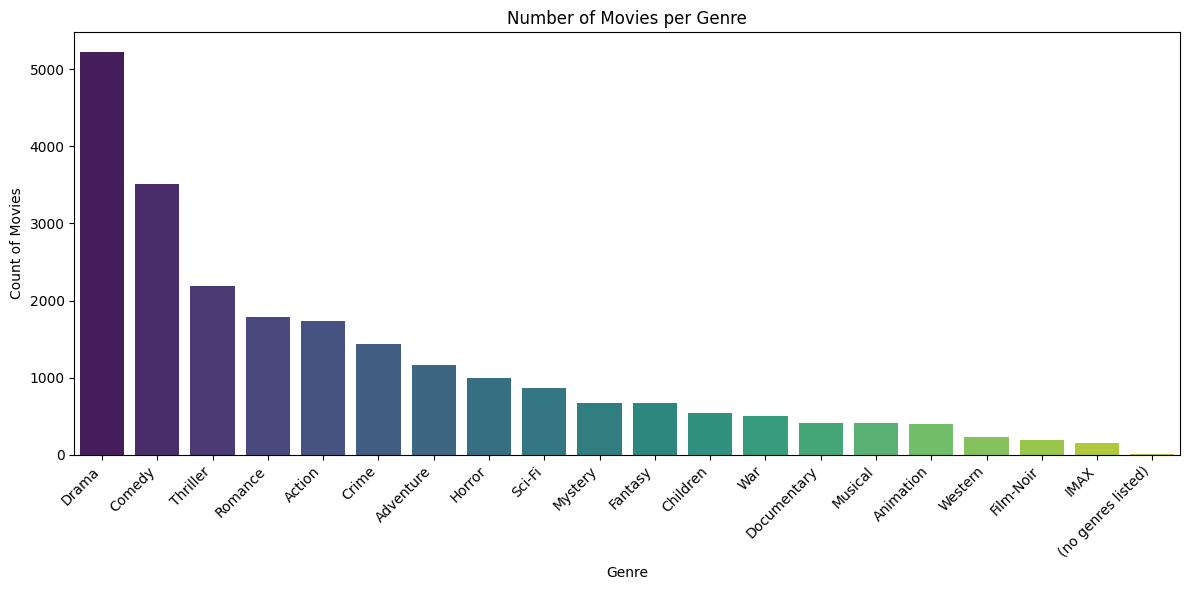

In [9]:
# Plot genre distribution of the movies dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load movies dataset
movies = pd.read_csv('movies.csv')

# Split the pipe-separated 'genres' column and explode it to get one genre per row
movies_exploded = movies.assign(genre = movies['genres'].str.split('|')).explode('genre')

# Count the number of movies per genre
genre_counts = movies_exploded['genre'].value_counts().sort_values(ascending=False)

# Display top of the count series
print(genre_counts.head())

# Plot
plt.figure(figsize=(12,6))
ax = sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Number of Movies per Genre')
plt.ylabel('Count of Movies')
plt.xlabel('Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
def pop_genre_recommender(genre, min_reviews=50, top_n=10):
    temp   = movies.explode('genres')
    target = temp[temp.genres == genre]          # ① filter
    merged = ratings.merge(target, on='movieId') # ② join
    stats  = merged.groupby(['movieId','title']).rating.agg(
                 ['mean','count']).reset_index()
    stats  = stats[stats['count'] >= min_reviews]# ③ threshold
    return stats.sort_values(['mean','count'], ascending=[False,False])\
                .head(top_n)\
                .rename(columns={'mean':'avg_rating','count':'num_reviews'})

 Implementation Highlights

# Interactive Widget (optional)

In [14]:
import ipywidgets as w
ui = w.interact(
        pop_genre_recommender,
        genre       = w.Dropdown(options=genres_unique),
        min_reviews = w.IntSlider(value=100,min=10,max=500,step=10),
        top_n       = w.IntSlider(value=5,min=1,max=20)
     )

NameError: name 'genres_unique' is not defined